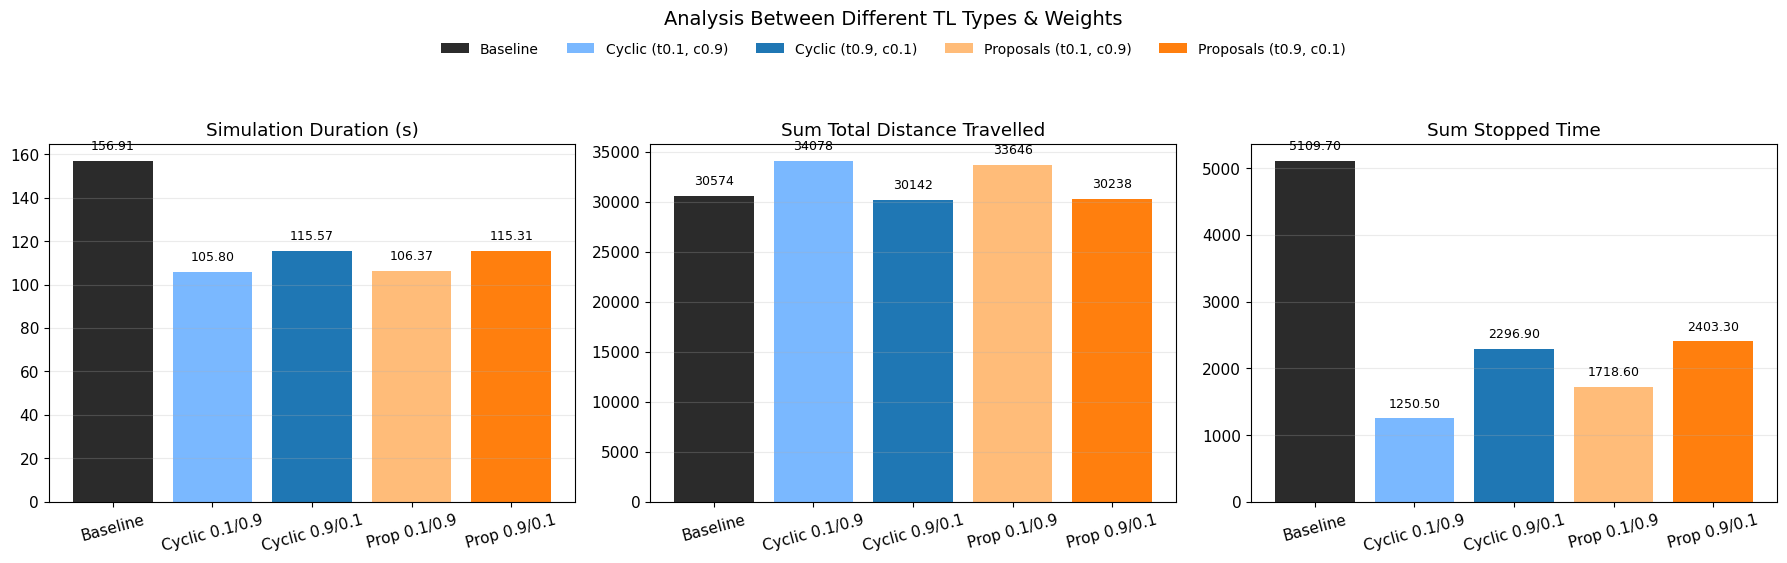

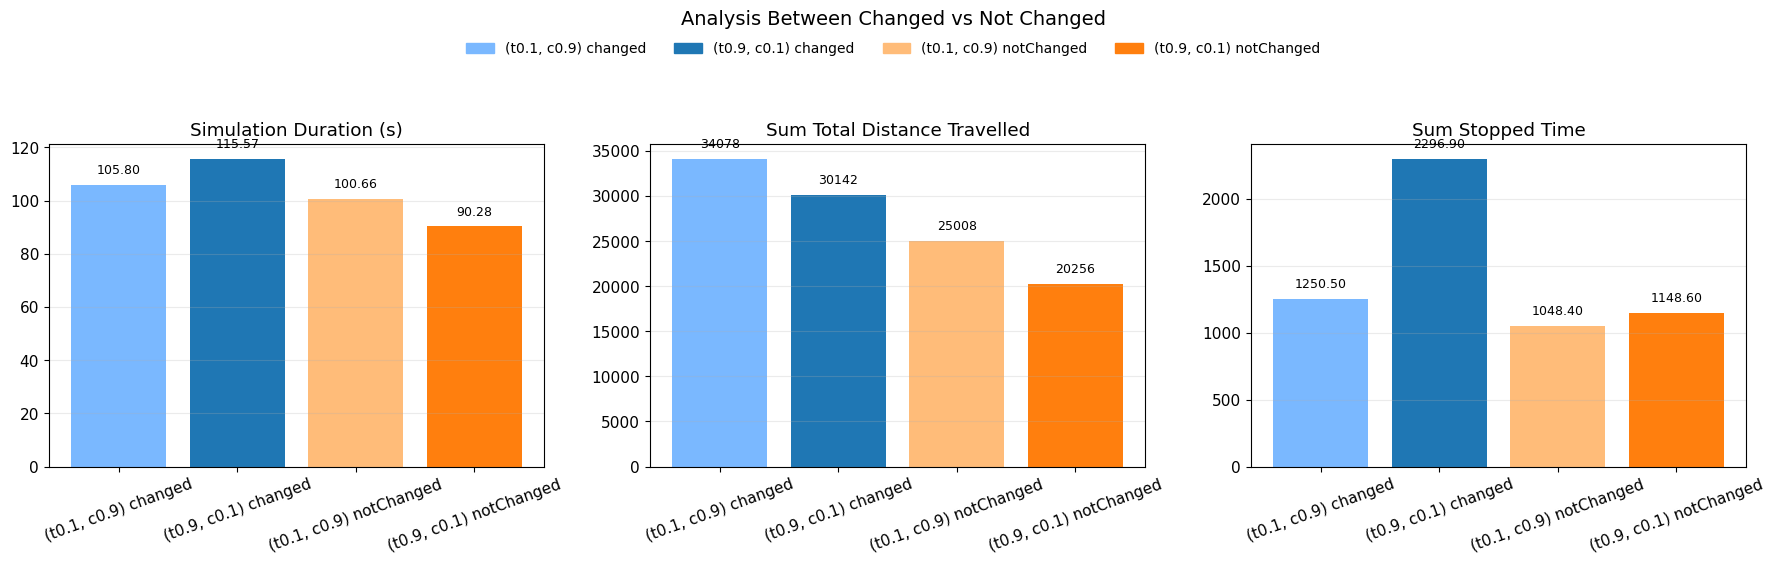

In [1]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# -------------------------
# CONFIG
# -------------------------
FOLDER = "simulation_results/summaries"

# NOVA PALETA (matplotlib default blue/orange + variações)
BASELINE_COLOR = "#2b2b2b"     # preto suave

CYCLIC_LIGHT = "#7ab8ff"       # azul claro
CYCLIC_DARK  = "#1f77b4"       # azul escuro (default)

PROP_LIGHT   = "#ffbc79"       # laranja claro
PROP_DARK    = "#ff7f0e"       # laranja escuro (default)

BAR_EDGE_COLOR = "none"

FONT_SIZE = 11
plt.rcParams.update({"font.size": FONT_SIZE})


# -------------------------
# 1) Ler ficheiros
# -------------------------
summary = {}
files = [f for f in os.listdir(FOLDER) if f.endswith("_summary.json")]

for fname in files:
    core = fname.replace("sim_", "").replace("_summary.json", "")
    travel, capacity, tl_type, adaptive, network = core.split("_")

    summary\
        .setdefault(travel, {})\
        .setdefault(capacity, {})\
        .setdefault(tl_type, {})\
        .setdefault(network, {})[adaptive] = json.load(open(os.path.join(FOLDER, fname)))


# -------------------------
# 2) Encontrar baseline
# -------------------------
baseline_loc = None
for travel in summary:
    for capacity in summary[travel]:
        for tl_type in summary[travel][capacity]:
            for network in summary[travel][capacity][tl_type]:
                if "adaptiveGreenFalse" in summary[travel][capacity][tl_type][network]:
                    baseline_loc = (travel, capacity, tl_type, network, "adaptiveGreenFalse")

baseline = summary[baseline_loc[0]][baseline_loc[1]][baseline_loc[2]][baseline_loc[3]][baseline_loc[4]]


# -------------------------
# 3) Helper
# -------------------------
def get_nested(d, path):
    cur = d
    for p in path.split("."):
        if p not in cur:
            return None
        cur = cur[p]
    return cur


# -------------------------
# 4) MÉTRICAS (3)
# -------------------------
METRICS = {
    "Simulation Duration (s)": "total_simulation_duration",
    "Sum Total Distance Travelled": "car_summary.sum_total_distance",
    "Sum Stopped Time": "car_summary.sum_waiting_behind_cars",
}


# -------------------------
# 5) cenários
# -------------------------
def require_scenario(travel, capacity, tl_type, network="changedNetwork", adaptive="adaptiveGreenTrue"):
    return summary[travel][capacity][tl_type][network][adaptive]

c01 = require_scenario("travel0.1", "capacity0.9", "cyclic")
p01 = require_scenario("travel0.1", "capacity0.9", "proposals")
c09 = require_scenario("travel0.9", "capacity0.1", "cyclic")
p09 = require_scenario("travel0.9", "capacity0.1", "proposals")

blocks = [baseline, c01, p01, c09, p09]


# -------------------------
# 6) Extrair valores
# -------------------------
def extract_values(metric_path, blocks):
    return [get_nested(b, metric_path) for b in blocks]


# -------------------------
# 7) Auto label
# -------------------------
def autolabel(ax, rects):
    for rect in rects:
        h = rect.get_height()
        ax.annotate(
            f"{h:.2f}" if isinstance(h, float) else f"{h:.0f}",
            xy=(rect.get_x() + rect.get_width()/2, h),
            xytext=(0, 6),
            textcoords="offset points",
            ha="center", va="bottom", fontsize=9
        )


# -------------------------
# 8) Legenda comum
# -------------------------
def build_legend(fig):
    patches = [
        Patch(facecolor=BASELINE_COLOR, label="Baseline"),
        Patch(facecolor=CYCLIC_LIGHT,   label="Cyclic (t0.1, c0.9)"),
        Patch(facecolor=CYCLIC_DARK,    label="Cyclic (t0.9, c0.1)"),
        Patch(facecolor=PROP_LIGHT,     label="Proposals (t0.1, c0.9)"),
        Patch(facecolor=PROP_DARK,      label="Proposals (t0.9, c0.1)"),
    ]
    fig.legend(
        handles=patches,
        loc="upper center",
        ncol=5,
        frameon=False,
        fontsize=10,
        bbox_to_anchor=(0.5, 1.08)
    )


# ============================================================
# FIGURA 1 — Comparison 1
# ============================================================
labels_t = ["Baseline", "Cyclic 0.1/0.9", "Cyclic 0.9/0.1", "Prop 0.1/0.9", "Prop 0.9/0.1"]
colors_t = [BASELINE_COLOR, CYCLIC_LIGHT, CYCLIC_DARK, PROP_LIGHT, PROP_DARK]

fig2, axs2 = plt.subplots(1, 3, figsize=(18, 5))
fig2.suptitle("Analysis Between Different TL Types & Weights", fontsize=14, y=1.12)

for ax, (metric_name, metric_path) in zip(axs2, METRICS.items()):
    vals_all = extract_values(metric_path, blocks)
    vals = [
        vals_all[0],   # baseline
        vals_all[1],   # cyclic 0.1
        vals_all[3],   # cyclic 0.9
        vals_all[2],   # prop 0.1
        vals_all[4]    # prop 0.9
    ]

    x = np.arange(len(vals))
    bars = ax.bar(x, vals, color=colors_t, edgecolor="none")

    ax.set_title(metric_name)
    ax.set_xticks(x)
    ax.set_xticklabels(labels_t, rotation=15)
    ax.grid(axis="y", alpha=0.25)
    autolabel(ax, bars)

build_legend(fig2)
plt.tight_layout()
plt.show()



# ============================================================
# FIGURA 2 — Comparison 2
# ============================================================
c01_ch  = summary["travel0.1"]["capacity0.9"]["cyclic"]["changedNetwork"]["adaptiveGreenTrue"]
c01_nch = summary["travel0.1"]["capacity0.9"]["cyclic"]["notChangedNetwork"]["adaptiveGreenTrue"]

c09_ch  = summary["travel0.9"]["capacity0.1"]["cyclic"]["changedNetwork"]["adaptiveGreenTrue"]
c09_nch = summary["travel0.9"]["capacity0.1"]["cyclic"]["notChangedNetwork"]["adaptiveGreenTrue"]

blocks_ch = [c01_ch, c09_ch, c01_nch, c09_nch]

labels_ch = [
    "(t0.1, c0.9) changed",
    "(t0.9, c0.1) changed",
    "(t0.1, c0.9) notChanged",
    "(t0.9, c0.1) notChanged"
]

colors_ch = [CYCLIC_LIGHT, CYCLIC_DARK, PROP_LIGHT, PROP_DARK]

fig3, axs3 = plt.subplots(1, 3, figsize=(18, 5))
fig3.suptitle("Analysis Between Changed vs Not Changed", fontsize=14, y=1.12)

for ax, (metric_name, metric_path) in zip(axs3, METRICS.items()):
    vals = extract_values(metric_path, blocks_ch)

    x = np.arange(len(vals))
    bars = ax.bar(x, vals, color=colors_ch, edgecolor="none")

    ax.set_title(metric_name)
    ax.set_xticks(x)
    ax.set_xticklabels(labels_ch, rotation=20)
    ax.grid(axis="y", alpha=0.25)
    autolabel(ax, bars)


fig3.legend(
    handles=[
        Patch(color=CYCLIC_LIGHT, label="(t0.1, c0.9) changed"),
        Patch(color=CYCLIC_DARK,  label="(t0.9, c0.1) changed"),
        Patch(color=PROP_LIGHT,   label="(t0.1, c0.9) notChanged"),
        Patch(color=PROP_DARK,    label="(t0.9, c0.1) notChanged"),
    ],
    loc="upper center",
    ncol=4,
    frameon=False,
    fontsize=10,
    bbox_to_anchor=(0.5, 1.08)
)

plt.tight_layout()
plt.show()
